Perform [box method](https://doi.org/10.1029/2007JF000927) by terminating [curvilinear boxes](https://doi.org/10.3189/2014JoG13J061) with terminus traces and write resulting geometry to disk

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point
from shapely.ops import split

# Flag to enable descriptive plots of box method
PLOT = False

# Read terminus boxes and traces
boxes = gpd.read_file("../data/terminus/terminus_boxes.geojson")
traces = gpd.read_file("../data/terminus/terminus_traces_1985_2023.geojson")

# To store trace-terminated boxes before combined
boxes_gdf = []

# Perform box method
for glacier, traces_glacier in traces.groupby(by="glacier"):
    # Sort traces by date and collect curvilinear box for current glacier
    traces_glacier = traces_glacier.sort_values(by="date", ascending=False)
    box_glacier = boxes.loc[boxes.glacier == glacier].reset_index()

    for _, trace in traces_glacier.iterrows():
        # Attempt to split box by terminus trace
        difference = split(box_glacier.geometry.item(), trace.geometry.geoms[0])

        # Relocate distances are null if box was split successfully
        start_relocate_distance = np.nan
        end_relocate_distance = np.nan

        # If split was unsuccessful then extend trace to fully intersect box
        if len(difference.geoms) == 1:
            # Alias necessary geometry
            box_poly = box_glacier.geometry.item().geoms[0]
            box_edge = box_poly.exterior
            trace_line = trace.geometry.geoms[0]
            trace_start_coords = trace_line.coords[0]
            trace_end_coords = trace_line.coords[-1]
            trace_start_point = Point(trace_start_coords)
            trace_end_point = Point(trace_end_coords)

            # Copy of trace where relocated start/end coords will be inserted
            trace_line_extended = list(trace_line.coords)

            # Trace start point falls within box, so we need to extend to edge
            if box_poly.contains(trace_start_point):
                start_interp = box_edge.interpolate(box_edge.project(trace_start_point))
                shifted = box_edge.interpolate(box_edge.project(start_interp) - 10)
                vector = np.array(start_interp.coords[0]) - np.array(shifted.coords[0])
                start_interp_extended = (vector[1], -vector[0]) / np.linalg.norm(vector)
                start_interp_extended = (
                    start_interp.x - start_interp_extended[0] * 50,
                    start_interp.y - start_interp_extended[1] * 50,
                )
                trace_line_extended[0] = start_interp_extended
                start_relocate_distance = start_interp.distance(trace_start_point)

            # Trace start point falls within box, so we need to extend to edge
            if box_poly.contains(trace_end_point):
                end_interp = box_edge.interpolate(box_edge.project(trace_end_point))
                shifted = box_edge.interpolate(box_edge.project(end_interp) + 50)
                vector = np.array(end_interp.coords[0]) - np.array(shifted.coords[0])
                end_interp_extended = (vector[1], -vector[0]) / np.linalg.norm(vector)
                end_interp_extended = (
                    end_interp.x + end_interp_extended[0] * 50,
                    end_interp.y + end_interp_extended[1] * 50,
                )
                trace_line_extended[-1] = end_interp_extended
                end_relocate_distance = end_interp.distance(trace_end_point)

            # Reconstructs trace line with new start and/or end coords
            trace_line_extended = LineString(trace_line_extended)

            # Splits box by interpolated trace
            difference = split(box_glacier.geometry[0], trace_line_extended)

            # Optional plot to display original and modified trace, plus terminated box
            if PLOT:
                box_glacier.geometry.plot(color="grey", alpha=0.5, edgecolor="black")
                plt.fill(*difference.geoms[1].exterior.xy, linewidth=1, c="red", alpha=0.2)
                plt.plot(*trace_line_extended.xy, linewidth=1, c="blue")
                plt.plot(*trace_line.xy, linestyle="-", linewidth=1, c="orange")
                plt.plot(*trace_start_coords, marker="o", markersize=2, c="green")
                plt.plot(*trace_end_coords, marker="o", markersize=2, c="red")
                plt.show()

        # Assign attributes from trace to trace-terminated box
        box_gdf = trace.drop(labels="geometry")
        box_gdf["geometry"] = difference.geoms[1]
        box_gdf["area"] = difference.geoms[1].area
        box_gdf["area_width_averaged"] = difference.geoms[1].area / box_glacier.width[0]
        box_gdf["start_relocate_distance"] = start_relocate_distance
        box_gdf["end_relocate_distance"] = end_relocate_distance
        box_gdf = gpd.GeoDataFrame(box_gdf).transpose()
        box_gdf = box_gdf.set_geometry("geometry").set_crs(3413)
        boxes_gdf.append(box_gdf)

# Concat trace-terminated boxes into one GeoDataFrame, sort, and save geometry to disk
boxes_gdf = pd.concat(boxes_gdf, ignore_index=True)
boxes_gdf = boxes_gdf.sort_values(by=["glacier", "date"])
boxes_gdf.to_file("../data/terminus/terminus_boxes_1985_2023.geojson", driver="GeoJSON")
boxes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1043 entries, 736 to 737
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   date                     1043 non-null   object  
 1   image_id                 982 non-null    object  
 2   satellite                982 non-null    object  
 3   quality                  1043 non-null   object  
 4   glacier                  1043 non-null   object  
 5   glacier_code             1043 non-null   object  
 6   source                   1043 non-null   object  
 7   geometry                 1043 non-null   geometry
 8   area                     1043 non-null   object  
 9   area_width_averaged      1043 non-null   object  
 10  start_relocate_distance  96 non-null     object  
 11  end_relocate_distance    131 non-null    object  
dtypes: geometry(1), object(11)
memory usage: 105.9+ KB


Convert to xarray.Dataset and calculate changes in terminus position relative to first observation

In [2]:
# Metadata for final Dataset
GLOBAL_ATTRS = {
    "author": "King, O. G.",
    "projection": "3413",
    "title": "Terminus traces for Daugaard-Jensen and Unnamed Uunartit Islands glaciers, Greenland, 1985-2024",
    "version": "2024-06-27",
}
VAR_ATTRS = {
    "glacier": {
        "description": "Glacier name, as taken from the Mouginot and others (2019) Greenland basins dataset",
    },
    "time": {
        "description": "Datetime of image used for terminus trace",
    },
    "image_id": {
        "description": "ID of satellite image used for terminus trace",
    },
    "satellite": {
        "description": "Name of imaging satellite",
    },
    "quality": {
        "description": "Quality flag of terminus trace",
        "units": "0=no issues/not supplied; 1=estimated, uncertain, or affected by cloud cover",
    },
    "source": {
        "description": "Source of terminus trace",
        "citation": [
            "Black=Black & Joughin (2022) https://doi.org/10.5067/DGBOSSIULSTD",
            "Brough=Brough and others (2023) https://doi.org/10.5281/zenodo.6904218",
            "Joughin=Joughin and others (2021) https://doi.org/10.5067/ESFWE11AVFKW",
            "King=King (2024) This study",
            "TermPicks_<AUTHOR>=Goliber and others (2021) https://doi.org/10.5281/zenodo.6557981",
        ],
    },
    "geometry_wkt": {
        "description": "Geometry of trace-terminated box",
        "type": "Well Known Text (WKT)",
    },
    "area": {
        "description": "Box area",
        "units": "metres squared [m2]",
    },
    "area_width_averaged": {
        "description": "Box area normalised by glacier width",
        "units": "metres squared [m2]",
    },
    "start_relocate_distance": {
        "description": "Distance from original start node to interpolated start node on box edge",
        "units": "metres",
    },
    "end_relocate_distance": {
        "description": "Distance from original end node to interpolated end node on box edge",
        "units": "metres",
    },
    "area_width_averaged_change": {
        "description": "Change in width-averaged box area relative to the earliest observation",
        "units": "metres squared [m2]",
    },
}

# Convert geometry to WKT (because xarray disallows arbitrary Python objects when writing NetCDF)
boxes_gdf["geometry_wkt"] = [geom.wkt for geom in boxes_gdf.geometry.values]

# Convert GeoDataFrame to xarray.Dataset
terminus_ds = boxes_gdf.set_index(["glacier", "date"]).to_xarray()

# Assign types to each dim/coord/var
terminus_ds = terminus_ds.rename(date="time")
terminus_ds = terminus_ds.drop_vars(["geometry", "glacier_code"])
terminus_ds["time"] = pd.to_datetime(terminus_ds.time)
terminus_ds["area"] = terminus_ds.area.astype(float)
terminus_ds["area_width_averaged"] = terminus_ds.area_width_averaged.astype(float)
terminus_ds["end_relocate_distance"] = terminus_ds.end_relocate_distance.astype(float)
terminus_ds["start_relocate_distance"] = terminus_ds.start_relocate_distance.astype(float)
terminus_ds["geometry_wkt"] = terminus_ds.geometry_wkt.astype(str)
terminus_ds["glacier"] = terminus_ds.glacier.astype(str)
terminus_ds["image_id"] = terminus_ds.image_id.astype(str)
terminus_ds["quality"] = terminus_ds.quality.astype(str)
terminus_ds["satellite"] = terminus_ds.satellite.astype(str)
terminus_ds["source"] = terminus_ds.source.astype(str)

# Calculate change in terminus position relative to first observation
terminus_area = terminus_ds.area_width_averaged.groupby("glacier")
terminus_baseline = terminus_ds.area_width_averaged.groupby("glacier").first().dropna("time").isel(time=0)
terminus_ds["area_width_averaged_change"] = terminus_area - terminus_baseline

# Assign metadata
terminus_ds = terminus_ds.assign_attrs(GLOBAL_ATTRS)
for key, val in VAR_ATTRS.items():
    terminus_ds[key] = terminus_ds[key].assign_attrs(val)

# Write final Dataset to disk
terminus_ds.to_netcdf("../data/terminus/terminus_1985_2023.nc")
terminus_ds

<xarray.Dataset> Size: 100MB
Dimensions:                     (glacier: 2, time: 904)
Coordinates:
  * glacier                     (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAME...
  * time                        (time) datetime64[ns] 7kB 1985-06-11 ... 2023...
Data variables:
    image_id                    (glacier, time) <U163 1MB 'LT05_L1TP_232009_1...
    satellite                   (glacier, time) <U17 123kB 'LANDSAT_5' ... 'nan'
    quality                     (glacier, time) <U3 22kB '0' 'nan' ... '1' 'nan'
    source                      (glacier, time) <U17 123kB 'TermPicks_Wood' ....
    area                        (glacier, time) float64 14kB 2.766e+07 ... nan
    area_width_averaged         (glacier, time) float64 14kB 5.533e+03 ... nan
    start_relocate_distance     (glacier, time) float64 14kB nan nan ... nan nan
    end_relocate_distance       (glacier, time) float64 14kB nan nan ... nan nan
    geometry_wkt                (glacier, time) <U13678 99MB 'POLYGON ((56072...
    area_width_averaged_change  (glacier, time) float64 14kB 427.6 nan ... nan
Attributes:
    author:      King, O. G.
    projection:  3413
    title:       Terminus traces for Daugaard-Jensen and Unnamed Uunartit Isl...
    version:     2024-06-27

Quick visualisation of terminus change data at Uunartit Islands glacier

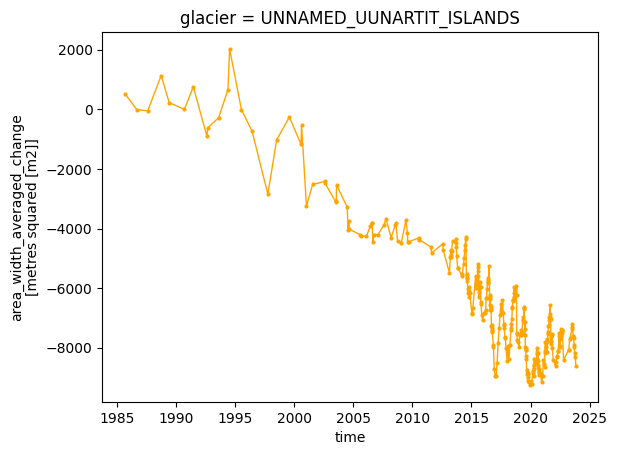

In [3]:
terminus_ds.area_width_averaged_change.sel(glacier="UNNAMED_UUNARTIT_ISLANDS").dropna("time").plot(
    c="orange", marker="o", markersize=2, linewidth=1
)

Figure X Width-averaged terminus position change relative to first observation

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from matplotlib.dates import DateFormatter, YearLocator
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Global plot settings
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Colours and label for each series
PLOT_SETTINGS = {
    "DAUGAARD-JENSEN": {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    "UNNAMED_UUNARTIT_ISLANDS": {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

# Set up axis
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0, 0])

# Load boxes and convert date column to datetime
terminus_ds = xr.open_dataset("../data/terminus/terminus_1985_2023.nc")

# Group terminus data by glacier
for glacier, terminus_ds_glacier in terminus_ds.groupby("glacier", squeeze=False):
    # Convert terminus change data to km
    terminus_change = terminus_ds_glacier.area_width_averaged_change.squeeze().dropna("time") / 1000
    ax.plot(
        terminus_change.time,
        terminus_change,
        label=PLOT_SETTINGS[glacier]["label"],
        marker="o",
        linewidth=2.5,
        markersize=3,
        markeredgecolor=PLOT_SETTINGS[glacier]["colour"][0],
        markerfacecolor=PLOT_SETTINGS[glacier]["colour"][0],
        color=PLOT_SETTINGS[glacier]["colour"][1],
    )

# Set y-axis range and add label
ax.set_ylim(bottom=-10, top=3)
ax.set_ylabel("Width-averaged terminus position \n change relative to first observation [km]", labelpad=20)

# Set x-axis range
ax.set_xlim(pd.to_datetime("1985-01-01"), pd.to_datetime("2024-01-01"))

# Format x-axis ticks: text format, frequency, rotation
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_major_locator(YearLocator(5))
ax.xaxis.set_minor_locator(YearLocator(1))
ax.tick_params(axis="x", rotation=70)

# Remove margin gap
ax.margins(x=0)

# Draw horizontal line at y=0
ax.axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))

# Draw grid
ax.grid(True, which="both", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)

# Draw axes label
ax.add_artist(AnchoredText("(x)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))

# # Add text describing direction of terminus change values
# ax.text(0.98, 0.95, "Advance ↑", alpha=0.8, size=18, ha="right", transform=ax.transAxes)
# ax.text(0.98, 0.88, "Retreat ↓", alpha=0.8, size=18, ha="right", transform=ax.transAxes)

plt.tight_layout()
plt.savefig("../img/terminus_ts.png", dpi=fig.dpi, bbox_inches="tight")
plt.show()